# P300 Speller with SVM

Here we begin by importing all the important libraries and by loading the pre-processed data in MatLab. The data are signals from the P300 Speller experiment described in the GitHub page. We have 5 different pre-processed data from 5 different patients. 

The task is to build a ML model that help to predict whether the signal is part of a visual stimulus or not:

- 1 is the signal is part of the stimulus;
- -1 otherwise.

In addition, we separated the data in two different categories:

- odb: the data where the label is 1;
- std: the data where the label is -1.

In [1]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import pandas as pd
import math

from scipy.io import loadmat
import scipy.io as sio
import seaborn as sns
import sklearn

from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit, cross_val_score

import keras
from keras import Sequential
from keras.layers import *
from keras.callbacks import *

import tensorflow as tf

In [2]:
odb_1 = scipy.io.loadmat('data/P1_odb_down.mat')
std_1 = scipy.io.loadmat('data/P1_std_down.mat')

odb_2 = scipy.io.loadmat('data/P2_odb_down.mat')
std_2 = scipy.io.loadmat('data/P2_std_down.mat')

odb_3 = scipy.io.loadmat('data/P3_odb_down.mat')
std_3 = scipy.io.loadmat('data/P3_std_down.mat')

odb_4 = scipy.io.loadmat('data/P4_odb_down.mat')
std_4 = scipy.io.loadmat('data/P4_std_down.mat')

odb_5 = scipy.io.loadmat('data/P5_odb_down.mat')
std_5 = scipy.io.loadmat('data/P5_std_down.mat')

## Processing Data

We take only the part of the data we will work with. The ".mat" files are like a dictionary, so we need to extract just the part with the data.

In [3]:
X_std_1 = std_1['E_std_down']
X_odb_1 = odb_1['E_odb_down']

X_std_2 = std_2['E_std_down']
X_odb_2 = odb_2['E_odb_down']

X_std_3 = std_3['E_std_down']
X_odb_3 = odb_3['E_odb_down']

X_std_4 = std_4['E_std_down']
X_odb_4 = odb_4['E_odb_down']

X_std_5 = std_5['E_std_down']
X_odb_5 = odb_5['E_odb_down']

Creating dataframes can help to better handle the data.

In [4]:
data_std_1 = pd.DataFrame(X_std_1)
data_odb_1 = pd.DataFrame(X_odb_1)

data_std_2 = pd.DataFrame(X_std_2)
data_odb_2 = pd.DataFrame(X_odb_2)

data_std_3 = pd.DataFrame(X_std_3)
data_odb_3 = pd.DataFrame(X_odb_3)

data_std_4 = pd.DataFrame(X_std_4)
data_odb_4 = pd.DataFrame(X_odb_4)

data_std_5 = pd.DataFrame(X_std_5)
data_odb_5 = pd.DataFrame(X_odb_5)

We created the label vectors:

In [5]:
data_odb_1['y'] = np.ones((150))
data_std_1['y'] = np.ones((1050))*(-1)

data_odb_2['y'] = np.ones((150))
data_std_2['y'] = np.ones((1050))*(-1)

data_odb_3['y'] = np.ones((150))
data_std_3['y'] = np.ones((1050))*(-1)

data_odb_4['y'] = np.ones((150))
data_std_4['y'] = np.ones((1050))*(-1)

data_odb_5['y'] = np.ones((150))
data_std_5['y'] = np.ones((1050))*(-1)

## Imbalanced Dataset

Since the dataset is imbalanced, we decided to downsample the data and take the same amount of value from the std data.

In [6]:
data_1 = pd.concat([data_odb_1,data_std_1[:150]])

data_2 = pd.concat([data_odb_2,data_std_2[:150]])

data_3 = pd.concat([data_odb_3,data_std_3[:150]])

data_4 = pd.concat([data_odb_4,data_std_4[:150]])

data_5 = pd.concat([data_odb_5,data_std_5[:150]])

Here we reshuffle the dataframe to avoid making the model learn a deterministic pattern.

In [7]:
data_1 = data_1.sample(frac=1, random_state=0)

data_2 = data_2.sample(frac=1, random_state=0)

data_3 = data_3.sample(frac=1, random_state=0)

data_4 = data_4.sample(frac=1, random_state=0)

data_5 = data_5.sample(frac=1, random_state=0)

And we created the X and y data as array to perform the last modification.

In [8]:
X_1 = data_1.loc[:, data_1.columns != 'y'].to_numpy()
y_1 = data_1['y'].to_numpy()

X_2 = data_2.loc[:, data_2.columns != 'y'].to_numpy()
y_2 = data_2['y'].to_numpy()

X_3 = data_3.loc[:, data_3.columns != 'y'].to_numpy()
y_3 = data_3['y'].to_numpy()

X_4 = data_4.loc[:, data_4.columns != 'y'].to_numpy()
y_4 = data_4['y'].to_numpy()

X_5 = data_5.loc[:, data_5.columns != 'y'].to_numpy()
y_5 = data_5['y'].to_numpy()

## Standardized Data

Variables that are measured at different scales do not contribute equally to the model fitting & model learned function and might end up creating a bias. Thus, to deal with this potential problem feature-wise standardized (μ=0, σ=1) is usually used prior to model fitting. Here there is the standardization:

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_1_std = scaler.fit_transform(X_1)

X_2_std = scaler.fit_transform(X_2)

X_3_std = scaler.fit_transform(X_3)

X_4_std = scaler.fit_transform(X_4)

X_5_std = scaler.fit_transform(X_5)

## Train-Test Split and X_train, y_train creation

We train-test split and create the X_train and y_train we will use to train the model. The last part is to reshuffle the data.

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [11]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1_std, y_1,
                                                            test_size=0.1, stratify=y_1, random_state=42)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2_std, y_2,
                                                            test_size=0.1, stratify=y_2, random_state=42)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3_std, y_3,
                                                            test_size=0.1, stratify=y_3, random_state=42)

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4_std, y_4,
                                                            test_size=0.1, stratify=y_4, random_state=42)

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5_std, y_5,
                                                            test_size=0.1, stratify=y_5, random_state=42)

We create the train as the union of the all train data from the 5 different patients.

In [12]:
X_train = np.vstack((X_train_1,X_train_2,X_train_3,X_train_4))
y_train = np.hstack((y_train_1,y_train_2,y_train_3,y_train_4))

And this is the last part were we shuffle the data to avoid other deterministic pattern.

In [13]:
data = pd.DataFrame(X_train)
data['y'] = y_train
data.head()

,0,1,2,3,4,5,6,7,8,9,...,127,128,129,130,131,132,133,134,135,y
0,1.430836,1.078124,0.325472,-0.257132,-0.678663,-1.266310,-1.131225,-0.114271,1.526363,0.230417,...,-0.374042,0.428108,0.494919,0.541443,-0.625490,-0.046604,-0.005975,-0.648095,0.017793,1.0
1,0.404253,-0.664945,-0.812230,-0.418725,-0.436707,-0.200638,0.550109,1.609472,0.207669,0.784649,...,0.664110,-0.339470,0.733363,-1.184289,1.472521,0.987418,-0.499976,-0.385905,-0.487583,-1.0
2,-1.109324,-0.849852,0.445107,0.032421,-0.723345,0.960236,-0.041948,-0.699620,-0.792444,0.439816,...,-1.562043,0.268086,0.118605,0.439580,1.133079,0.712399,0.077000,-0.729052,-0.249662,-1.0
3,0.768406,0.479360,0.861883,0.779610,1.291613,0.045876,-0.150509,-0.158907,0.350779,-0.708267,...,0.387941,0.621212,-1.040548,-0.805404,-0.402308,-1.201806,0.863859,-0.239232,1.206397,1.0
4,0.387547,0.631630,0.273774,0.049799,-0.789375,0.273200,-0.081125,0.245377,0.484055,-0.470547,...,0.725006,1.245003,-0.203622,1.180171,-0.645822,0.564838,-0.317559,-0.571817,0.630544,1.0


In [14]:
data = data.sample(frac=1, random_state=0)

In [15]:
X_train = data.loc[:, data.columns != 'y'].to_numpy()
y_train = data['y'].to_numpy()

## Autoencoder

Here we tried to use an autoencoder to have a feature embedding. The results are quite good.

In [16]:
model = Sequential([Dense(136, activation = 'relu'),
Dense(1000, activation = 'relu'),
Dense(500, activation = 'relu'),
Dense(200, activation = 'relu'),
Dense(136, activation = 'relu', name = 'encoder'),
Dense(200, activation = 'relu'),
Dense(500, activation = 'relu'),
Dense(1000, activation = 'relu'),
Dense(136)])

opt = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam")


model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=['mae','acc'])

earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=25, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5',
                           save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.1, patience=7,
                                   verbose=1, min_delta=1e-4, mode='min')

In [17]:
history = model.fit(X_train, X_train, epochs = 1000,
                    batch_size = 256, verbose = 0) #callbacks=[earlyStopping],

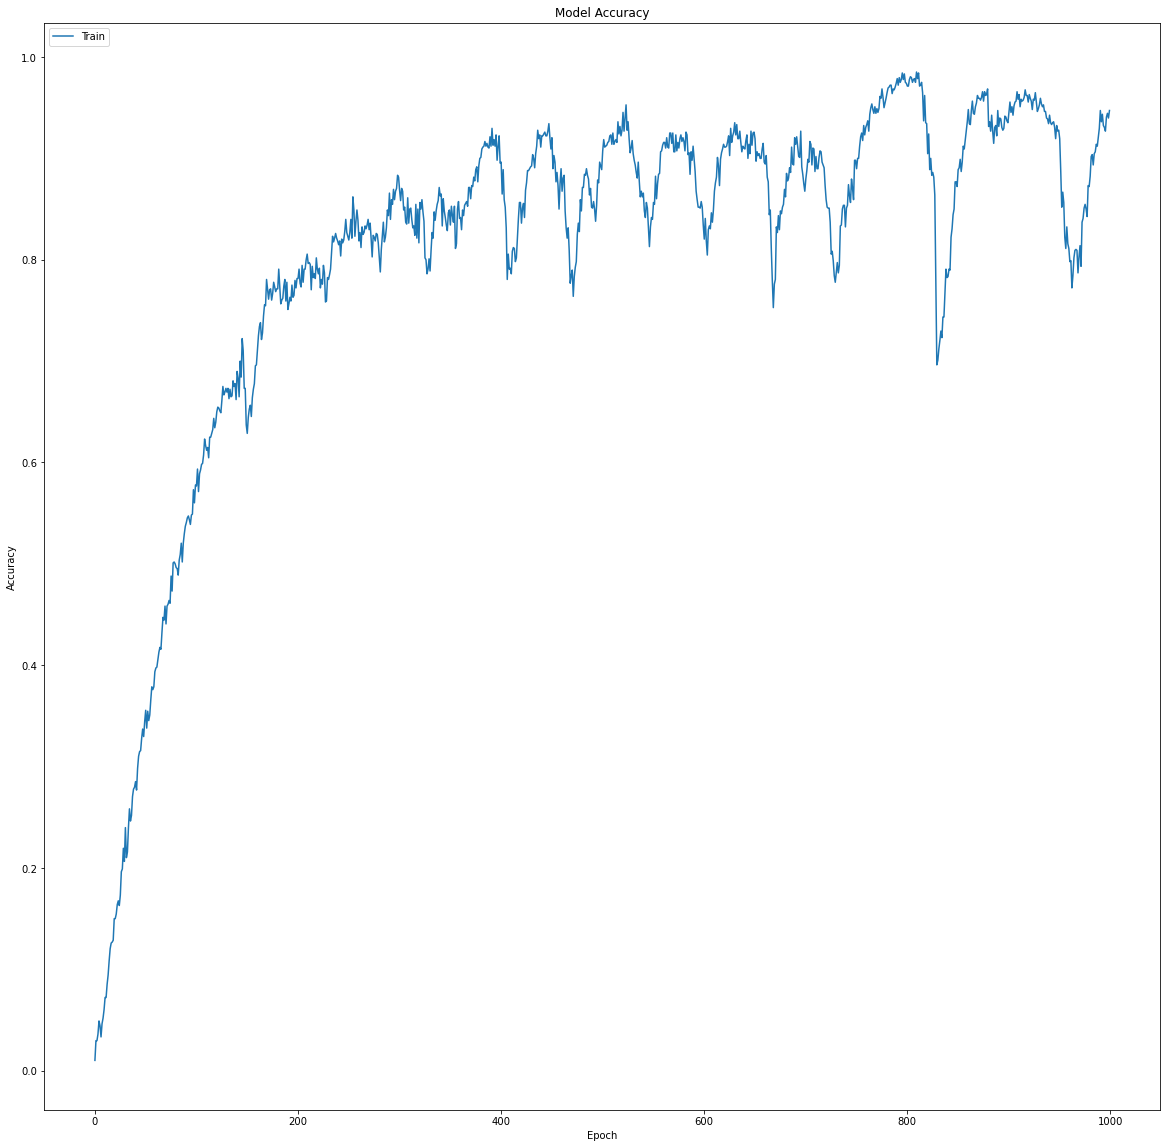

In [18]:
plt.figure(figsize = (20,20))
plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

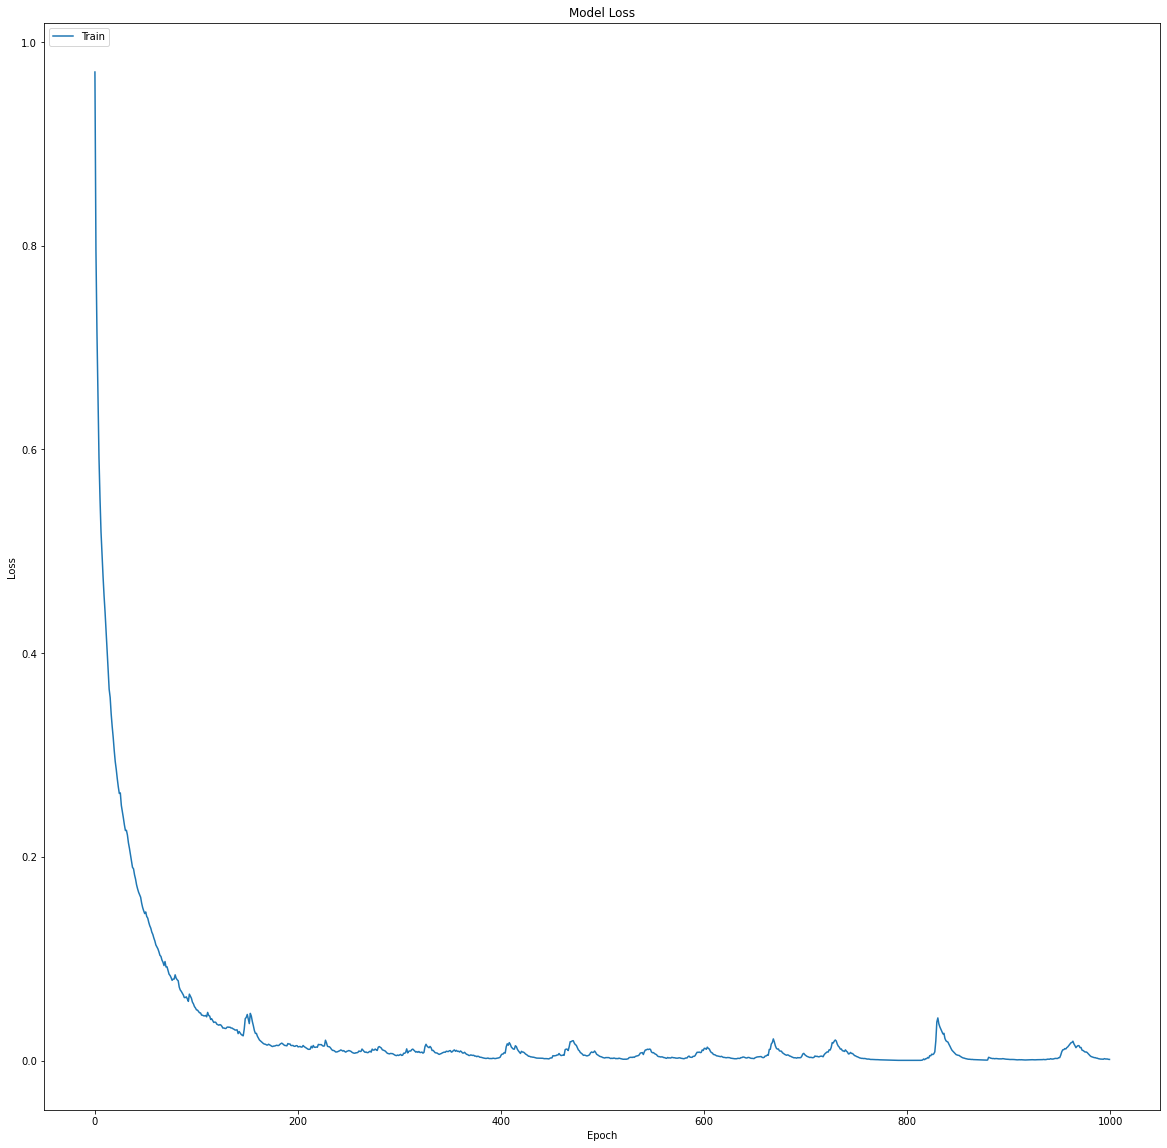

In [19]:
plt.figure(figsize = (20,20))
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [20]:
intermediate_layer_model = keras.Model(inputs=model.input,
                                 outputs=model.get_layer('encoder').output)
intermediate_output = intermediate_layer_model.predict(X_train)

In [21]:
intermediate_output[0]

array([4.1284165 , 0.        , 1.3424108 , 0.        , 1.7591951 ,
       0.        , 2.3370183 , 0.7290954 , 0.673679  , 0.8176451 ,
       0.93068326, 1.1177771 , 3.7294579 , 1.0241681 , 1.2644105 ,
       1.4792693 , 0.        , 0.        , 0.        , 2.6147165 ,
       1.2423748 , 0.6121576 , 0.        , 0.        , 1.6116027 ,
       0.        , 2.1803079 , 1.6817538 , 0.849808  , 0.        ,
       1.4316226 , 2.141551  , 1.2531664 , 0.        , 1.030691  ,
       3.2170866 , 0.5888656 , 0.        , 1.5163077 , 4.9671597 ,
       0.        , 0.        , 0.90112835, 0.        , 0.10764848,
       1.3405808 , 3.1632137 , 1.908873  , 0.        , 0.        ,
       3.1104012 , 0.44691414, 0.        , 0.        , 0.67901796,
       4.641141  , 1.1834981 , 2.5853117 , 3.5847301 , 5.6648774 ,
       4.0446777 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 3.9215631 , 1.2430059 , 3.1083565 , 0.        ,
       0.        , 0.        , 0.        , 4.66453   , 1.21266

Here is a comparison between the original data and the embedding data.

Text(0, 0.5, '$\\mu$V')

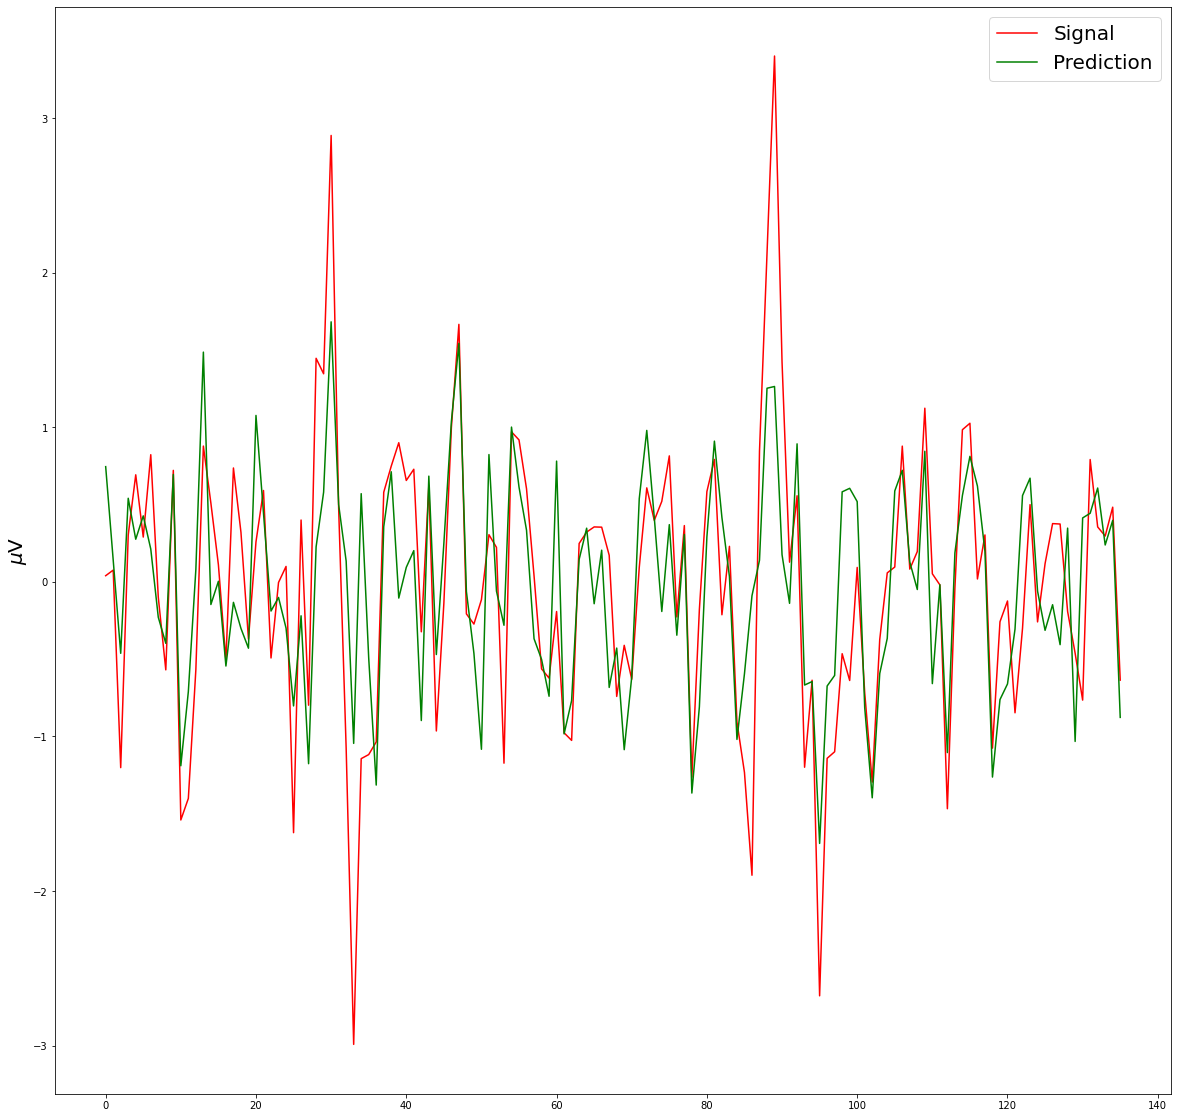

In [22]:
predictions = model.predict(X_test_1)
plt.figure(figsize = (20,20))
plt.plot(X_test_1[0], color = 'red', label='Signal')
plt.plot(predictions[0], color = 'green', label='Prediction')
plt.legend(fontsize=20)
plt.ylabel('$\mu$V', fontsize = 20)

## Model Selection

In [23]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier

#svc = svm.SVC(kernel='rbf')
#clf = MultiOutputClassifier(svc)
#clf = RandomForestClassifier(max_depth=100, random_state=0)
#clf = LinearDiscriminantAnalysis()
#clf = MLPClassifier(random_state=1, max_iter=3400)
clf = svm.SVC(kernel='rbf')
clf = clf.fit(np.hstack((intermediate_output,X_train)), y_train)

In [24]:
from sklearn.metrics import roc_curve

In [25]:
X_test_1_label = intermediate_layer_model.predict(X_test_1)

y_pred_1 = clf.predict(np.hstack((X_test_1_label,X_test_1)))

report_1 = classification_report(y_test_1, y_pred_1)  
print(report_1)

              precision    recall  f1-score   support

        -1.0       0.78      0.93      0.85        15
         1.0       0.92      0.73      0.81        15

    accuracy                           0.83        30
   macro avg       0.85      0.83      0.83        30
weighted avg       0.85      0.83      0.83        30



In [26]:
X_test_2_label = intermediate_layer_model.predict(X_test_2)

y_pred_2 = clf.predict(np.hstack((X_test_2_label,X_test_2)))

report_2 = classification_report(y_test_2, y_pred_2)  
print(report_2)

              precision    recall  f1-score   support

        -1.0       0.87      0.87      0.87        15
         1.0       0.87      0.87      0.87        15

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.87      0.87      0.87        30



In [27]:
X_test_3_label = intermediate_layer_model.predict(X_test_3)

y_pred_3 = clf.predict(np.hstack((X_test_3_label,X_test_3)))

report_3 = classification_report(y_test_3, y_pred_3)  
print(report_3)

              precision    recall  f1-score   support

        -1.0       0.71      0.67      0.69        15
         1.0       0.69      0.73      0.71        15

    accuracy                           0.70        30
   macro avg       0.70      0.70      0.70        30
weighted avg       0.70      0.70      0.70        30



In [28]:
X_test_4_label = intermediate_layer_model.predict(X_test_4)

y_pred_4 = clf.predict(np.hstack((X_test_4_label,X_test_4)))

report_4 = classification_report(y_test_4, y_pred_4)  
print(report_4)

              precision    recall  f1-score   support

        -1.0       0.75      1.00      0.86        15
         1.0       1.00      0.67      0.80        15

    accuracy                           0.83        30
   macro avg       0.88      0.83      0.83        30
weighted avg       0.88      0.83      0.83        30



In [29]:
X_test_5_label = intermediate_layer_model.predict(X_test_5)

y_pred_5 = clf.predict(np.hstack((X_test_5_label,X_test_5)))

report_5 = classification_report(y_test_5, y_pred_5)  
print(report_5)

              precision    recall  f1-score   support

        -1.0       0.79      0.73      0.76        15
         1.0       0.75      0.80      0.77        15

    accuracy                           0.77        30
   macro avg       0.77      0.77      0.77        30
weighted avg       0.77      0.77      0.77        30



## Final Score

We decleared that the third patient is an outlier. The model perform with a good score on 4 patients, but not on the third one.

So, we printed the mean of all the F1-Scores and Precision Scores. These is the score that our model can perform.

In [30]:
from sklearn.metrics import precision_recall_fscore_support as score

In [31]:
precision1,recall1,fscore1,support1 = score(y_test_1, y_pred_1,average='macro')
precision2,recall2,fscore2,support2 = score(y_test_2, y_pred_2,average='macro')
precision3,recall3,fscore3,support3 = score(y_test_3, y_pred_3,average='macro')
precision4,recall4,fscore4,support4 = score(y_test_4, y_pred_4,average='macro')
precision5,recall5,fscore5,support5 = score(y_test_5, y_pred_5,average='macro')

In [32]:
print("F1-Score : {}".format(
    (fscore1 + fscore2 + fscore4 + fscore5)/4))

print("Precision : {}".format(
    (precision1 + precision2 + precision4 + precision5)/4))

F1-Score : 0.8233237614772653
Precision : 0.839186507936508
